In [ ]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
data_path = "/content/gdrive/MyDrive/Digital-Pathology/imgs"

In [ ]:
os.listdir(data_path)

['TFrecords', 'BACH_Poster', 'Microscopy_Images', 'data', 'run_bach.ipynb']

In [ ]:
img = Image.open(os.path.join(data_path, "Microscopy_Images", "Invasive", "iv003.tif"))

In [ ]:
img.size

(2048, 1536)

In [ ]:
img_arry = np.array(img)

In [ ]:
img_arry.shape

(1536, 2048, 3)

In [ ]:
def slide_extract_patches(slide_path, patch_size, patch_path):
  slide = Image.open(slide_path)
  uuid = slide_path.split("/")[-1].split(".")[0]

  slide_width, slide_height = slide.size
  patch_width, patch_height = patch_size

  patches = list()
  for left in range(0, slide_width, patch_width):
    for top in range(0, slide_height, patch_height):
      right, bottom = left + patch_width, top + patch_height
      crop_box_coords = (left, top, right, bottom)
      patch = slide.crop(crop_box_coords)
      patches.append(patch)

      if len(patch_path)>1:
        slide_patch_path = os.path.join(patch_path, uuid)
        os.makedirs(slide_patch_path, exist_ok=True)
        patch.save(f"{slide_patch_path}/{uuid}_left_{left}_top_{top}_right_{right}_bottom_{bottom}_patch.png")

  expect_num_patches = (slide_width * slide_height) // (patch_width * patch_height)
  assert expect_num_patches == len(patches), print(f"we excpted to have total number of {expect_num_patches} patches been extracted, however, we ended up with only {len(patches)} patches have been extracted")

  return patches


In [ ]:
patches = slide_extract_patches(
    slide_path=os.path.join(data_path, "Microscopy_Images", "Benign", "b003.tif"),
    patch_size=(256,256),
    patch_path='content/patches'
)

In [ ]:
from keras.api._v2.keras.applications import resnet50
def customize_res50(
    res_weights = "imagenet",
    res_layer = "conv4_block1_0_conv",
    res_top=False,
    res_trainable=False,
    input_shape=(256,256,3)
):
  restnet50_model=tf.keras.applications.resnet50.ResNet50(
      include_top=res_top, weights=res_weights, input_shape=input_shape
  )
  resnet50.trainable=res_trainable

  custom_res50_model = tf.keras.Model(
      inputs=restnet50_model.input, outputs=restnet50_model.get_layer(res_layer).output
  )
  adaptive_mean_spatial_layer = tf.keras.layers.GlobalAveragePooling2D()
  return custom_res50_model, adaptive_mean_spatial_layer

In [ ]:
custom_res50_model, adaptive_mean_spatial_layer = customize_res50(
    res_weights = "imagenet",
    res_layer = "conv4_block1_0_conv",
    res_top=False,
    res_trainable=False,
    input_shape=(256,256,3)
)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
def create_img_embeddings(
    patches,
    custom_res50_model,
    adaptive_mean_spatial_layer
):
  embeddings = list()
  for patch in patches:
    patch_ary = np.resize(
        np.array(patch),
        (1,patch.size[0],patch.size[1],3)
    )
    res50_feature = custom_res50_model(patch_ary)
    embedding = adaptive_mean_spatial_layer(res50_feature)
    embeddings.append(embedding)
  assert len(patches)==len(embeddings), print(f"we have {len(patches)} patches, however, we only have {len(embeddings)} embeddings")
  return embeddings


In [ ]:
embeddings = create_img_embeddings(
    patches,
    custom_res50_model,
    adaptive_mean_spatial_layer
)

In [ ]:
len(embeddings), len(patches)

(48, 48)

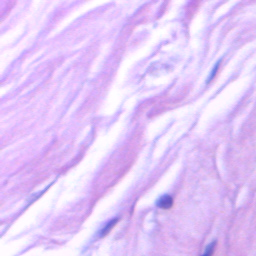

In [ ]:
patches[0]

In [ ]:
embeddings[0]

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[-1.6661199 , -0.5769947 ,  0.28456616, ..., -1.0646405 ,
         0.363487  ,  0.04103531]], dtype=float32)>